# Modeling

In [9]:
#standard imports
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#load data
data = pd.read_csv('data.csv', index_col=0)
data.head(1)

,text,target
0,welcome team thanks joining team name kathleen...,Liberal


# Train Test Split
* Conduct train, test, validation split early to prevent leakage
* Stratify target within test and validation sets to account for imbalance

In [4]:
from sklearn.model_selection import train_test_split

X = data['text'].astype(str)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.35, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size = 0.2, stratify=y_test)

print('Sizes: ')
print('X_train: ', {X_train.shape})
print('X_test: ', {X_test.shape})
print('X_val: ', {X_val.shape})

Sizes: 
X_train:  {(205725,)}
X_test:  {(88620,)}
X_val:  {(22156,)}


In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc= le.fit_transform(y_train)
y_test_enc= le.transform(y_test)

target_classes = le.classes_

# Baseline Model
Baseline is the average occurance of the target variables. Meaning, if a model was to guess the majority class it would be correct ~78% of the time. 

In [5]:
y_train.value_counts(normalize=True)

Liberal         0.782545
Conservative    0.211107
Center          0.006348
Name: target, dtype: float64

# Modeling
When approaching modeling I will use an iterative approach: model, evaluate, parameter tuning, further modeling. When turning does not improve scores, I will adjust my the transformer or modeling methods. 

### Imports

In [105]:
#Pipleine
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from graphviz import *
from sklearn.linear_model import SGDClassifier

#Evaluation Imports
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            cohen_kappa_score, plot_confusion_matrix

### Evaluation Functions

In [10]:
eval_scores_tracker = pd.DataFrame(columns=['iteration', 'model', 'cross_val', 'accuracy','precision','recall','f1','cohen-kappa'])

In [68]:
#evaluation functions
def model_evaluation(iteration, model, X_tr, y_tr, X_te, y_te): 
    '''
    Evaluates model and returns accuracy, precision, recall, F1, roc-auc scores, 
    plots a confusion matrix and ROC-AUC graph.
    
    Inputs: 
    model: model fitted to X_tr
    X_tr: Training variable
    y_tr: Training target
    X_te: Test variable
    y_te: Test target
    '''

    preds = model.predict(X_te)

    #score model from metrics
    avg_cros_val = cross_val_score(model, X_tr, y_tr, cv=3).mean()
    accuracy = accuracy_score(y_te, preds)
    precision = precision_score(y_te, preds, average='micro')
    recall = recall_score(y_te, preds, average='micro')
    f1 = f1_score(y_te, preds, average='micro')
    cohen_kappa = cohen_kappa_score(y_te, preds)

    #store scores
    scores = [[iteration, model, avg_cros_val, accuracy, precision, recall, f1, cohen_kappa]]
    scores_df = pd.DataFrame(scores, columns=['iteration', 'model', 'cross_val', 'accuracy','precision','recall','f1','cohen-kappa'])
    eval_scores_tracker.append(scores_df)

    #plot confusion matrix
    plot_confusion_matrix(model, X_te, y_te, display_labels=target_classes, normalize='true')

    return scores_df

def evaluaton_tracker(scores_df):
    '''Inputs a model's scores captured in a dataframe. 
       Appends scores to with other scores for comparison'''
    eval_scores_tracker.append(scores_df)
    return eval_scores_tracker

## Models

### MultinomialNB with CountVectorizer

In [19]:
#Create a MultinomialNB modeling pipeline with Count Vectorizer
ctvec_bayes_pipe = make_pipeline(CountVectorizer(),
                                 MultinomialNB())

#Fit model
ctvec_bayes_pipe.fit(X_train, y_train_enc)                               

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,1,"(CountVectorizer(), MultinomialNB())",0.94079,0.937508,0.937508,0.937508,0.937508,0.834296


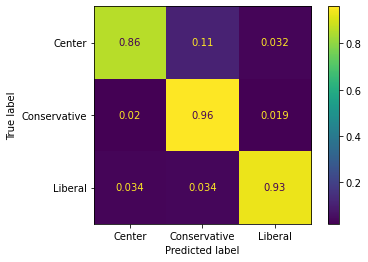

In [39]:
#Evaluate model
model_evaluation(1, ctvec_bayes_pipe, X_train, y_train_enc, X_test, y_test_enc)

The model accurately identifies the idology of emails ~93.8% of the time. It is most accurate with identifying conservative ideology, followed by liberal, and center. Next I will tune parameters with the aim of improving the accuracy of the `center` targets.

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,2,"(CountVectorizer(), MultinomialNB(alpha=0.5))",0.932721,0.93005,0.93005,0.93005,0.93005,0.817566


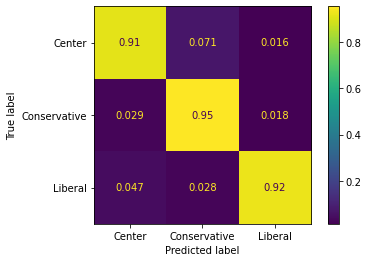

In [67]:
#Tune alpha parameter
ctvec_bayes_pipe.set_params(multinomialnb__alpha=0.5) 

#fit model
ctvec_bayes_pipe.fit(X_train, y_train_enc) 

#Evaluate
model_evaluation(2, ctvec_bayes_pipe, X_train, y_train_enc, X_test, y_test_enc)

Tuning alpha to 0.5 decreased the overall accuracy score, but increased the accuracy of classifying `center` targets, which was my initial goal. This model is most likely to confuse `center` as `conservative`. The accuracy of the `liberal` target also decreased with more `liberal` emails being classified as `center` than before.

I will conduct a GridSearch of parameters on the pipleine to find the `best_params_` that produce the highest accuracy score. Code guide for GridSearch in pipeline: [https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)

In [74]:
#reset params of model
ctvec_bayes_pipe.set_params(multinomialnb__alpha=None)

#create param grid to search
param_grid = {'countvectorizer__min_df': [1, 2, 5, 50],
          'countvectorizer__max_features': [None, 1000, 2000],
          'multinomialnb__alpha': [0.75, 1]}


#gridsearch and pring best_param results
search = GridSearchCV(ctvec_bayes_pipe, param_grid=param_grid)
search.fit(X_train, y_train_enc)
print(search.best_params_)

{'countvectorizer__max_features': None, 'countvectorizer__min_df': 1, 'multinomialnb__alpha': 1}


In [78]:
ctvec_bayes_pipe.set_params(multinomialnb__alpha=1)
ctvec_bayes_pipe.fit(X_train, y_train_enc)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=1))])

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,NB2,"(CountVectorizer(), MultinomialNB(alpha=1))",0.94079,0.937508,0.937508,0.937508,0.937508,0.834296


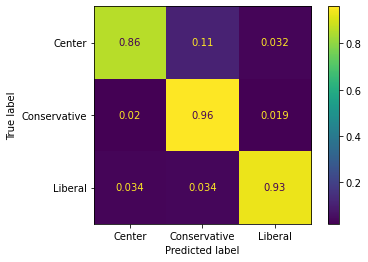

In [79]:
model_evaluation("NB2", ctvec_bayes_pipe, X_train, y_train_enc, X_test, y_test_enc)

### DecisionTree with Count Vectorizer

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,tree1,"(CountVectorizer(min_df=0.02), DecisionTreeCla...",0.941252,0.943049,0.943049,0.943049,0.943049,0.821123


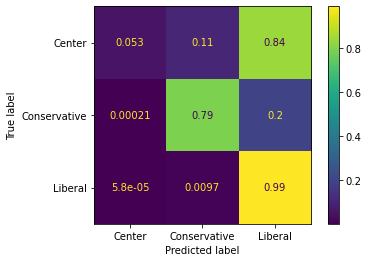

In [84]:
#Create a DecisionTree with CountVectorizer
tree_pipe = Pipeline([('vectorizer', CountVectorizer(min_df=0.02)),
                      ('tree', DecisionTreeClassifier(random_state=42, max_depth=10))])

#Fit to model
tree_pipe.fit(X_train, y_train_enc)

#Evaluate model
model_evaluation('tree1', tree_pipe, X_train, y_train_enc, X_test, y_test_enc)

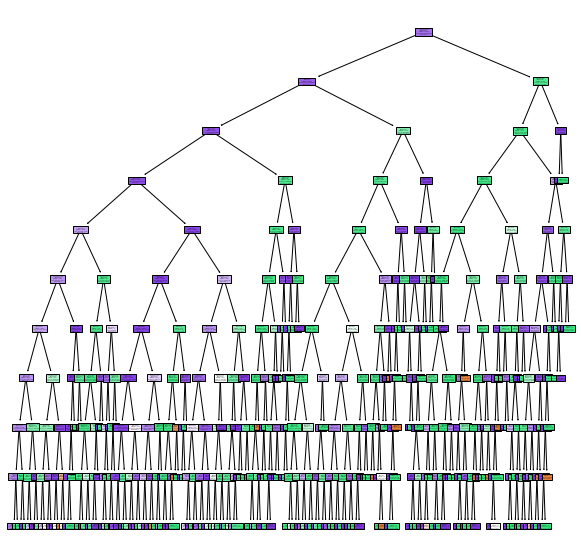

In [89]:
#Plot Tree
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(tree_pipe['tree'], 
               feature_names = tree_pipe['vectorizer'].get_feature_names(), 
               class_names= target_classes, 
               filled = True)

plt.show();

In [98]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

,0
fewer,0.284083
privacy,0.126273
conservative,0.095600
actblue,0.058074
believe,0.047825


The first decison tree had an accuracy score of ~94%. It performed well in classifying `liberal` ideology of emails with 99% accuracy. It was less accurate when predicting `center`  and emails, they were only correctly predicted 5% of the time. Correctly predicting`conservative` emails with this decision tree were also less acurate than previous Naive Bayes models. 

A benifit of DecisionTrees is the ability to learn the feature importances the model used. The word 'privacy` was considered as the most important feature in this model. 

Moving forward in decision tree modeling, I will I will pass through a `class_weight` parameter with the goal of improving the accuracy of classifiying `center` and `conservative`

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,tree2,"(CountVectorizer(min_df=0.02), DecisionTreeCla...",0.791571,0.791627,0.791627,0.791627,0.791627,0.547441


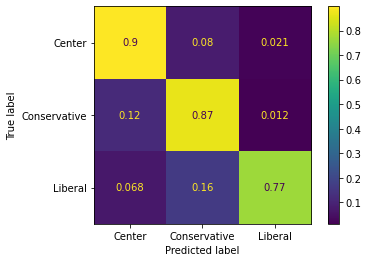

In [96]:
#tune parameters
tree_pipe.set_params(tree__class_weight ='balanced')

#fit
tree_pipe.fit(X_train, y_train_enc)

model_evaluation('tree2', tree_pipe, X_train, y_train_enc, X_test, y_test_enc)

Tuning the parameter `class_weights` to balanced had the desired effect of correctly predicting more `center` and `conservative` emails. This came at the cost of accuracy within the `liberal` and target. The accuracy score dropped to 79% which is only slightly better than our baseline (guessing) model. 

In [97]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

,0
fewer,0.284083
privacy,0.126273
conservative,0.095600
actblue,0.058074
believe,0.047825


'fewer' is considered the most important feature in this model, as compared to 'privacy' from the previous decision tree model. Interstinly, The top words in both cases are not intuative! In future modeling, I would like to include feature engineered variables into the decision tree. 

In the next phase of modling, I will tune the vectorizer rather than the decision tree. 

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,tree3,"(CountVectorizer(max_df=0.99, min_df=0.05), De...",0.95862,0.962469,0.962469,0.962469,0.962469,0.890453


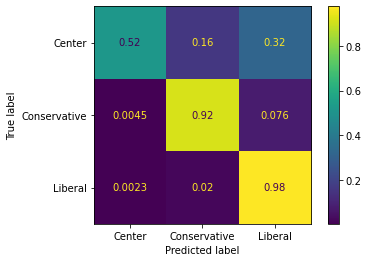

In [111]:
#remove tree parameters and adjust vectorizer
tree_pipe.set_params(tree__max_depth=None, tree__class_weight=None,
                     vectorizer__min_df=0.05, vectorizer__max_df=0.99)

#Fit
tree_pipe.fit(X_train, y_train_enc)

#Evaluate
model_evaluation('tree3', tree_pipe, X_train, y_train_enc, X_test, y_test_enc)

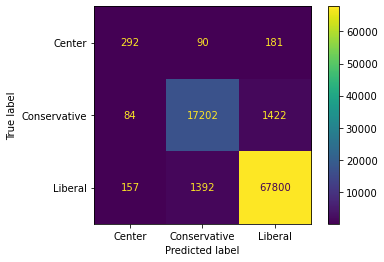

In [103]:
plot_confusion_matrix(tree_pipe, X_test, y_test_enc, display_labels=target_classes) #no normalizatoin

This tree is the most accurate so far with a 96% accuracy score. It improves from tree1 in in its `center` and `conservative` target predictions while only suffering 1% decrease accuracy of `liberal` email predictions. As with tree1 model the model was most likely to make an error by classifying `center` emails as `liberal`. 

When observing the nonnormalized confusion matrix, the class imabalnce becomes apparent as there are so few `center` emails compared to `liberal` emails. While 7% of conservative emails are mis-identified, compared to 32% of `center` emails, 7% of conservative emails represents a greater proportion of the corpus overall (1,422 emails compared to 181 emails). 

In [101]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

,0
privacy,0.265888
conservative,0.133553
liberal,0.056164
fewer,0.053462
paid,0.038439


### Stochastic Gradient Descent (SGD)

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,sgdc1,"(CountVectorizer(), SGDClassifier())",0.989316,0.990702,0.990702,0.990702,0.990702,0.972851


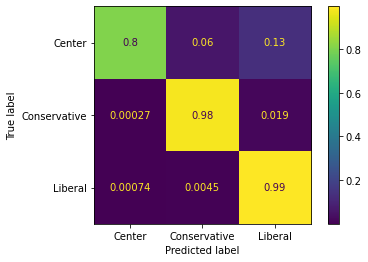

In [130]:
#Make SGDC pipline
sgdc_pipe = make_pipeline(CountVectorizer(),
                          SGDClassifier())

#Fit
sgdc_pipe.fit(X_train, y_train_enc)

#Evaluation
model_evaluation('sgdc1', sgdc_pipe, X_train, y_train_enc, X_test, y_test_enc)

In [132]:
#Finding the feature importances
features = sgdc_pipe['countvectorizer'].get_feature_names()
coefficients = sgdc_pipe['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

This model performed very well! With 99% accuracy! The model accurately classifyies both `liberal` and `conservative` emails, and captures a majority of the `center` ideology emails. The accuracy of each target corresponds with the proportion of the target within the dataset (liberal is the highest accuracy and the most observed label in the dataset, vice versa with center.) Perhaps the imbalance within the target partially contributes to the results. In the next model I will tune the class_weights of the SGDClassifier to 'balanced'.

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,sgdc2,"(CountVectorizer(), SGDClassifier(class_weight...",0.987678,0.988479,0.988479,0.988479,0.988479,0.966688


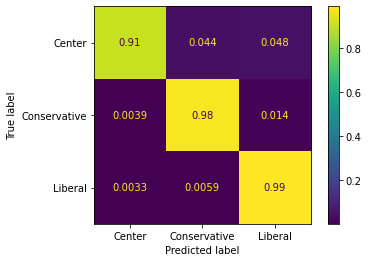

In [137]:
#Make SGDC2 pipline
sgdc_pipe = make_pipeline(CountVectorizer(),
                          SGDClassifier(class_weight='balanced',
                                        random_state=42))

#Fit
sgdc_pipe.fit(X_train, y_train_enc)

#Evaluation
model_evaluation('sgdc2', sgdc_pipe, X_train, y_train_enc, X_test, y_test_enc)

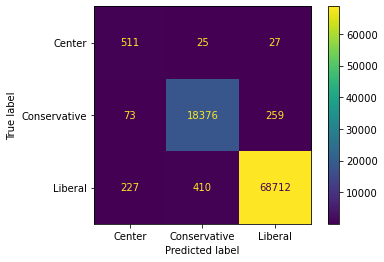

In [140]:
plot_confusion_matrix(sgdc_pipe, X_test, y_test_enc, display_labels=target_classes) #not normalized

In [138]:
#Finding the feature importances
features = sgdc_pipe['countvectorizer'].get_feature_names()
coefficients = sgdc_pipe['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

,features,values,abs_val
27167,garbarino,3.823415,3.823415
38435,labels,3.664436,3.664436
50707,palzewicz,3.535424,3.535424
39078,lawler,3.245631,3.245631
33733,independent,2.957484,2.957484
16238,cwa,2.842450,2.842450
46580,nan,-2.828916,2.828916
59304,rock,2.608237,2.608237
9374,byrne,2.599994,2.599994
75740,weber,2.522172,2.522172


So far, the SGDClassifier models are accurate on training and testing data. However, after inspecting the important features of the model many are names which may not be generalizeable to future classification situations and impact how this model performs on unseen data. 

##  SGDClassifier with binary variable
In this series of modeling, I am to explore if the features of a SGDClassifer model would be more generalizable using a binary target. I will train/test/split the data again after creating a binary target then model again with SGDClassifier and CountVectorizer.

In [169]:
#create new dataframe of only Liberal and Conservative emails
data2 = data.loc[data['target'] != "Center"].copy() 

#reproduce train/test/split with binary target
X2 = data2['text'].astype(str)
y2 = data2['target']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, test_size=0.35, stratify=y2)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_test2, y_test2, random_state=42, test_size = 0.2, stratify=y_test2)

#encode binary target
y_train_enc2= le.fit_transform(y_train2)
y_test_enc2= le.transform(y_test2)

target_classes = le.classes_ #keeping this as 'target_classes' for use in model_evaluation function

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,sgdc_binary,"(CountVectorizer(), SGDClassifier())",0.990921,0.99196,0.99196,0.99196,0.99196,0.975898


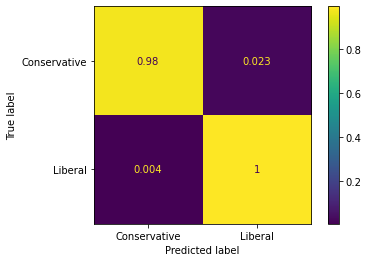

In [167]:
#Make SGDC pipline for binary target. Use same parameters as before
sgdc_binary = make_pipeline(CountVectorizer(),
                           SGDClassifier(random_state=42))

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
model_evaluation('sgdc_binary', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)

In [168]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

,features,values,abs_val
48731,opt,-1.167156,1.167156
33048,inc,-1.049789,1.049789
10325,castle,-0.984584,0.984584
39233,liberal,-0.919380,0.919380
20837,edit,-0.906339,0.906339
22386,error,0.870477,0.870477
16932,deductible,0.854176,0.854176
61704,shaun,-0.844395,0.844395
74685,weld,-0.834615,0.834615
39250,libertarian,-0.831354,0.831354


The top features of this list are different from the multi-class target. It contains fewer names and more politically-charged words. 

In the next model I will tune the vectorizer to reduce the demensionality of the words. 

,iteration,model,cross_val,accuracy,precision,recall,f1,cohen-kappa
0,sgdc_binary2,"(CountVectorizer(max_df=0.99, min_df=0.02), SG...",0.973437,0.973347,0.973347,0.973347,0.973347,0.919019


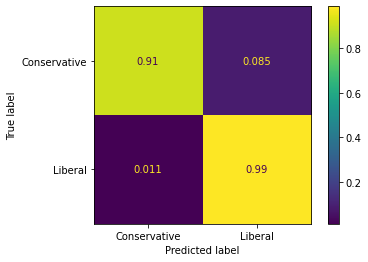

In [172]:
#Set parameter
sgdc_binary.set_params(countvectorizer__min_df=0.02, countvectorizer__max_df=0.99)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
model_evaluation('sgdc_binary2', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)

In [173]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

,features,values,abs_val
629,liberal,-1.796267,1.796267
282,deductible,1.607304,1.607304
9,actblue,1.529495,1.529495
772,opt,-1.451686,1.451686
466,gifts,1.418340,1.418340
796,patriot,-1.413894,1.413894
797,patriots,-1.340531,1.340531
168,charitable,-1.331639,1.331639
1033,socialist,-1.282730,1.282730
220,conservatives,-1.182691,1.182691


In [174]:
print(f'{len(feature_importances)} features in sgdc_binary2')

1266 features in sgdc_binary2


Reducing the number of features decreased the accuracy score from 99% to 97%. The model continues to perform well and better than the baseline. For the next model I will tune the CountVectorizer to allow for more features with the aim of increasing the accuracy score. 

In [ ]:
#adjust max_df parameter
sgdc_binary.set_params(countvectorizer__max_df=1.0, countvectorizer__min_df=0.01)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
model_evaluation('sgdc_binary3', sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2)

Error: Session cannot generate requests